### Installations, if needed

In [ ]:
!pip install spacy==2.0.12 # Above 2.0.12 doesn't seem work with the neuralcoref resolution (at least 2.0.13 and 2.0.16 don't)

### Importing Libraries

In [2]:
import spacy
from spacy import displacy
import pandas as pd
import networkx as nx
from graphviz import Source

### Loading and previewing our export from OntoNotes5

In [3]:
JSON_FILENAME = 'ner_output_1.json'
FILEPATH_TO_JSON = "onto_sql_output/"

onto_import = pd.read_json(FILEPATH_TO_JSON + JSON_FILENAME)

In [ ]:
onto_import.head()

### Downloading and loading the large spaCy English pipeline

In [ ]:
# Download the english medium-sized pipeline
! python -m spacy download en_core_web_lg

In [4]:
nlp = spacy.load('en_core_web_lg')

### Looping through dependency parsing for all sentences

In [5]:
onto_import["spacy_parse"] = onto_import.apply(lambda x: nlp(x["sentence_string"]), axis=1)

### Viewing the text, with highlighted named entities

In [6]:
# Choose an entry integer to see its text and the parse below.
ENTRY = 490

displacy.render(onto_import.loc[ENTRY,"spacy_parse"], jupyter=True, style='ent')

### Viewing dependencies

In [7]:
displacy.render(onto_import.loc[ENTRY,"spacy_parse"], jupyter=True, style='dep')

### Identifying some useful attributes of the spaCy tokens

In [8]:
# This gives us the dependency type

onto_import.loc[490,"spacy_parse"][13]

the

In [9]:
# This gives us the token of its head, from which we can call other attributes of the head.

onto_import.loc[490,"spacy_parse"][13].head.i

16

In [10]:
# If we just want the string of the head, that's here:

onto_import.loc[0,"spacy_parse"][32].head.text

'summit'

In [11]:
# If we want the index of the head within the sentence (to find when a multi-word NE
# depends on something outside of that NE phrase)

onto_import.loc[0,"spacy_parse"][32].head.i

35

### Creating a Dictionary with a Graph for Each NER Type

In [12]:
graphs_dict = dict()

### Graphing a row

In [13]:
def graph_row(df_row):
    
    # Retrieve our Directed Graph for this NE Type or create a new one
    G = graphs_dict.get(df_row["ner_type"], nx.Graph(rank='same'))
    
    # For each row, add a node for the Named Entity's type
    G.add_node(df_row["ner_type"])

    # If it's a phrase, let's find the node that reaches outside the range of this phrase:
    head_index = df_row["ner_end_word_index"]
    head_of_phrase = df_row["spacy_parse"][head_index]
        
    # Get the explanation of its dependency type in this usage
    explanation = spacy.explain(head_of_phrase.dep_)
    
    # If no explanation, revert to the raw dependency type.
    if explanation is None:
        explanation = head_of_phrase.dep_
    
    # Trying to catch and diagnose some problem cases
    elif explanation == "punctuation":
        print("NE '{1}' marked as punctuation in sentence '{0}'".format(df_row["sentence_string"], df_row["ner_string"]))
        print(" --- ")
    elif explanation == "determiner":
        print("NE '{1}' marked as determiner in sentence '{0}'".format(df_row["sentence_string"], df_row["ner_string"]))
        print(" --- ")

    # Object of preposition doesn't do much, so let's see what's on the other side of that.
    elif explanation == "object of preposition":
        explanation = "head of prep phrase"
        # move to the preposition so we get its head later on when adding node
        head_of_phrase = head_of_phrase.head
        
    # Add a node for that explanation, and connect that to the main entity
    G.add_node(explanation)
    G.add_edge(df_row["ner_type"], explanation)
    
    # Add a node from the dependency type to the head of the phrase head's index, and connect that
    # to the dependency type
    G.add_node(head_of_phrase.head.norm_)
    G.add_edge(explanation, head_of_phrase.head.norm_)
    
    graphs_dict[df_row["ner_type"]] = G

In [14]:
_ = onto_import.loc[0:1000,:].apply(lambda x: graph_row(x), axis=1)

NE 'U.S.' marked as punctuation in sentence 'In recent months , there have been been anti-U.S. and anti-Israel demonstrations in Yemen , despite efforts to establish more friendly ties .'
 --- 
NE 'Israel' marked as punctuation in sentence 'In recent months , there have been been anti-U.S. and anti-Israel demonstrations in Yemen , despite efforts to establish more friendly ties .'
 --- 
NE 'Yemen' marked as punctuation in sentence 'In recent months , there have been been anti-U.S. and anti-Israel demonstrations in Yemen , despite efforts to establish more friendly ties .'
 --- 
NE 'American' marked as punctuation in sentence 'The U.S. believes there are anti-American terror groups based in Yemen .'
 --- 
NE 'the `` USS Cole ''' marked as punctuation in sentence 'ABC News has learned that the terrorists who attacked the `` USS Cole '' originally planned to hit a different American warship in the same port ten months earlier .'
 --- 
NE 'The `` USS Cole ''' marked as punctuation in sente

#### Draw the graphs

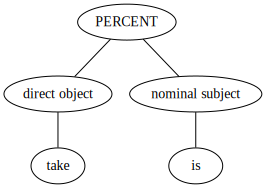

In [15]:
for key, value in graphs_dict.items():

    # Write our graph to DOT format to be read and visualized by GraphViz
    nx.drawing.nx_pydot.write_dot(value,'graph_dot.txt')

    graph_filepath = 'NER_Type_Graphs/'
    graph_filename = 'G_' + key

    # Load the saved DOT format
    graph_visualized = Source.from_file('graph_dot.txt')

    # Save it to a png
    graph_visualized.render(filename=graph_filepath + graph_filename, format='svg')

# View one in the notebook
graph_visualized